#1. Header with Contributions

##An Analysis of Goodreads Book Reviews
Fall 2024 Data Science Project

by:
*   Alec Ding, UID: 118754499
*   Katherine Krotkov, UID: 118852690
*   Anvay Panguluri, UID: 119227169
*   Tanmay Panguluri, UID: 119227213

Contributions:
*   Alec Ding
  * []
*   Katherine Krotkov
  * Created the heatmap visualization and wrote the insights/conclusion section. Also worked on the "page count vs language code" in the exploratory data analysis section.
*   Anvay Panguluri
  * I wrote the data cleaning and transformation portions of the Data Exploration and Summary Statistics section, also adapting the work done in Checkpoint 2. I also assisted in the design and development of the ML algorithm, and I did the Data Curation and Preprocessing section.
*   Tanmay Panguluri
  * Worked on the ML algorithm design/development and on the ML algorithm training and test data analysis. Used data prepared in section 4 to write section 5: Primary Analysis.

#2. Introduction

The Goodreads book reviews dataset is a dataset that catalogues each book listed on Goodreads, including title, ISBN, Author, publisher, rating, and rating count. We are trying to answer the question of whether the average rating of a book can be predicted, given the other fields provided, such as publication date, number of pages, ratings_count, text_reviews_count, etc.

This analysis is useful because it can provide an insight into what makes a book well-reviewed, whcih can help readers select better books to read.

#3. Data Curation

[This](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks/data) is the source of our dataset. The site is Kaggle, a site where high-quality public datasets are available.

We first add the required libraries to parse in the dataset:

In [1]:
import pandas as pd
import gdown
import os
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

And then we load the dataset into a pandas dataframe.

In [ ]:
# Downloading the dataset; this cell needs only to be run once to get the csv
# file into the Google Colab Notebook.
url = "https://drive.google.com/uc?id=1yexdWwAjBcYM58T-J2J4d_pEhOx494FF"
output = "books.csv"
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

# Loading the data into a DataFrame.
books_df = pd.read_csv("books.csv", on_bad_lines='skip')
books_df_original = books_df.copy()

Downloading...
From: https://drive.google.com/uc?id=1yexdWwAjBcYM58T-J2J4d_pEhOx494FF
To: /content/books.csv
100%|██████████| 1.56M/1.56M [00:00<00:00, 46.4MB/s]


The data is now ready for analysis.

#4. Exploratory Data Analysis

We will now examine the dataset.

In [ ]:
books_df.shape

(11123, 12)

As can be seen, there are 11,123 records and 12 features in the dataset.

Here is a preview of the dataset:

In [ ]:
books_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


We can explicitly give the columns:

In [ ]:
books_df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

and datatypes of those columns:

In [ ]:
books_df.dtypes

,0
bookID,int64
title,object
authors,object
average_rating,float64
isbn,object
isbn13,int64
language_code,object
num_pages,int64
ratings_count,int64
text_reviews_count,int64


The datatypes are in a mix of strings and integers. Since we wish to perform linear regression on this data (which will be explained later), we will need to transform all the string data into numerical data. This can be accomplished through label encoding, which will be done later.

We can also examine some summary statistics of the columns with numerical data where such summary statistics make sense. That is to say, taking the median or average of ISBN numbers makes little sense, since ISBNs are not continuous variables like num_pages, ratings_counts, or average_ratings is.

In [ ]:
books_df[['average_rating', '  num_pages', 'ratings_count', 'text_reviews_count']].describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,3.934075,336.405556,1.794285e+04,542.048099
std,0.350485,241.152626,1.124992e+05,2576.619589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,47.000000
75%,4.140000,416.000000,5.000500e+03,238.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


You might notice that the column '  num_pages' is incorrectly formatted; there are leading spaces. This can be solved by using the strip() function on all the column names.

In [ ]:
books_df.columns = books_df.columns.str.strip()

In order to apply linear regression to the dataset, the columns we want to analyze have to be numerical. Some of the columns are in string or date form, which will not work.

So, these must be encoded.

First off, we can convert the publication date into a unix time value to turn it into a number.


In [ ]:
import datetime as dt
# books_df['publication_date'] = pd.to_datetime(books_df['publication_date'], format="%m/%d/%Y", errors="coerce", origin="unix")
books_df = books_df[pd.to_datetime(books_df["publication_date"], errors="coerce").notna()]
books_df['publication_date'] = books_df["publication_date"].apply(lambda x: pd.Timestamp(x).timestamp())

books_df

<ipython-input-9-e3b1191506dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['publication_date'] = books_df["publication_date"].apply(lambda x: pd.Timestamp(x).timestamp())


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,1.158365e+09,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,1.093997e+09,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,1.067645e+09,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,1.083370e+09,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,1.095034e+09,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,1.103587e+09,Da Capo Press
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,5.969376e+08,Penguin Books
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,7.441632e+08,Penguin Books
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,1.172534e+09,Ecco


Now, we will perform one-hot encoding for the languages. This will be used later in the model training. The publisher, author, and name will be ignored (and dropped later) as they do not contribute meaningfully to the rating.



In [ ]:
books_df = pd.get_dummies(books_df, columns=["language_code"])
books_df["language_code"] = books_df_original["language_code"]
books_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho,language_code
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,1.158365e+09,...,False,False,False,False,False,False,False,False,False,eng
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,870,2153167,29221,1.093997e+09,...,False,False,False,False,False,False,False,False,False,eng
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,352,6333,244,1.067645e+09,...,False,False,False,False,False,False,False,False,False,eng
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,435,2339585,36325,1.083370e+09,...,False,False,False,False,False,False,False,False,False,eng
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,2690,41428,164,1.095034e+09,...,False,False,False,False,False,False,False,False,False,eng


### Now we will examine the data to adjust it for transformation.

First, we can examine num_pages.

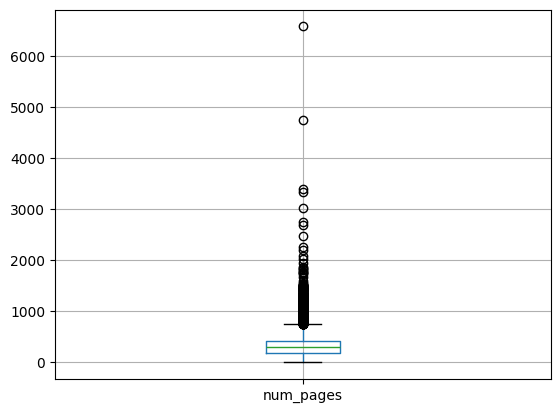

In [ ]:
books_df[["num_pages"]].boxplot()
plt.show()

This appears to be a logarithmic distribution, with many short books and few long books. We will apply a logistic transform to this feature. There are two vastly longer books at the top, above 4000 pages, which will mess with how precise our data is. We will remove those.

Next, ratings_count:

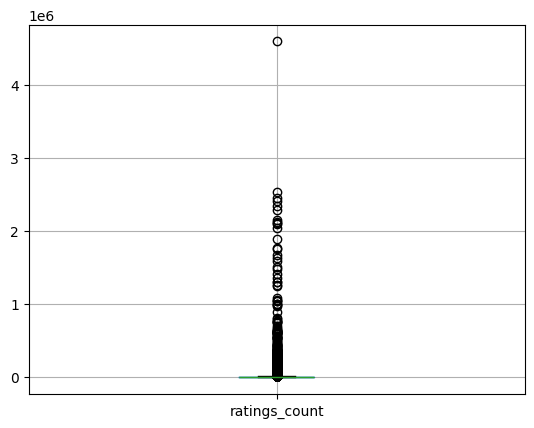

In [ ]:
books_df[["ratings_count"]].boxplot()
plt.show()

Don't be distracted by the strange y ticks, that's 1 million.

It looks like there's one book very high up with over 4,000,000 reviews (it's Twilight) that we won't be able to predict with such little data at that range. We'll remove that one.

Next, text_reviews_count:

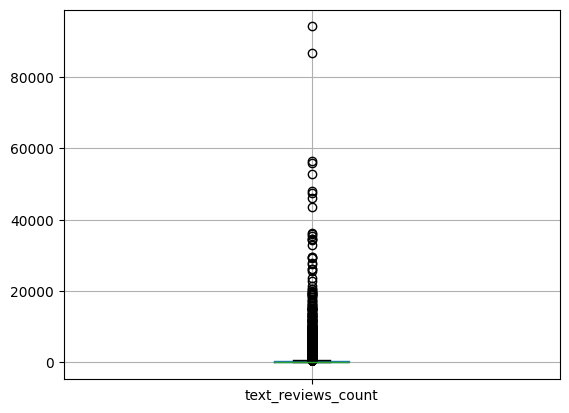

In [ ]:
books_df[["text_reviews_count"]].boxplot()
plt.show()

We can remove the books above 80000 text reviews here. Removing outliers:

In [ ]:
# Originally removed pages above 700
# 692 books saved
books_df = books_df[books_df["num_pages"] <= 4000]
# Originally removed ratings above 3000 or 10000
# 3,476 books or 1,960 books saved
books_df = books_df[books_df["ratings_count"] <= 4000000]
# Originally removed text review count above 150 (wtf?)
# 7,638 books saved
books_df = books_df[books_df["text_reviews_count"] <= 80000]

print(f"{len(books_df_original) - len(books_df)} outliers were removed in total.")

6 outliers were removed in total.


### We will now perform an exploratory data analysis through three hypothesis tests.


In [ ]:
# Importing the required libraries to perform hypothesis tests:
import matplotlib.pyplot as plt
from scipy import stats

1. Let us use the ANOVA test to analyze the relationship between language and the number of reviews.

$H_0$: Language has no effect on the number of reviews.

$H_A$: Language has an effect on the number of reviews.

$\alpha$ = 0.05

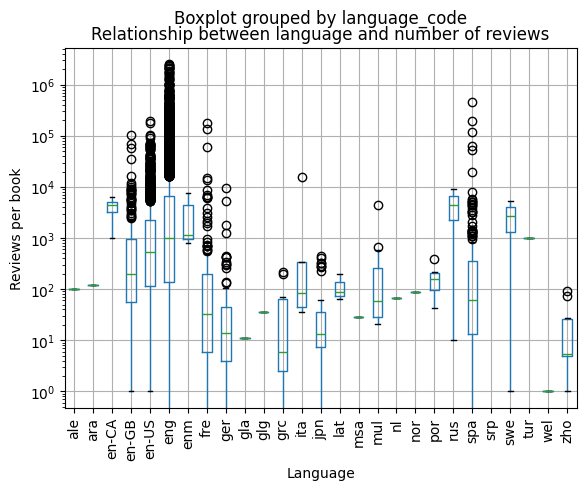

In [ ]:
books_df[["language_code", "ratings_count"]].boxplot(by="language_code")
plt.xlabel("Language")
plt.ylabel("Reviews per book")
plt.title("Relationship between language and number of reviews")
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

As we can see from the boxplot, there is a decent variation between the languages for the number of reviews books get. There also appears to be a lot of extremely highly reviewed outlier books in the dataset as well.

In [ ]:
# Performing the ANOVA test:
samples = [x[1] for x in books_df.groupby("language_code")["ratings_count"]]
f_val, p_val = stats.f_oneway(*samples)
p_val

0.0018465084952005032

As can be seen by the p-value, which is lower than $\alpha$ (0.0018 < 0.05), language has a statistically significant effect on the number of reviews that a book has. This is likely due to different languages having a larger reader base than other, more niche languages, or simply that Goodreads is an English website, and that English-like Indo-European language are more supported and popular to host than other languages, which would be hosted on a different site.

2. Let us perform an ANOVA test to measure whether the means of the average rating for a publisher's set of books differ from each other.

$H_0$ : The mean average rating of books do not differ based on the books' publishers.

$H_A$ : The mean average rating of books do differ based on the books' publishers.

$\alpha$ = 0.05

In [ ]:
# Performing the ANOVA test
test1_group = books_df.groupby("publisher")['average_rating'].apply(list)
f_statistic, p_value = stats.f_oneway(*test1_group)
f_statistic, p_value

(3.3881463525531057, 0.0)

The p-value = 0. Since the p-value is less than $\alpha$, therefore we reject the null hypothesis and conclude that the mean average rating of books do differ based on their publishers.

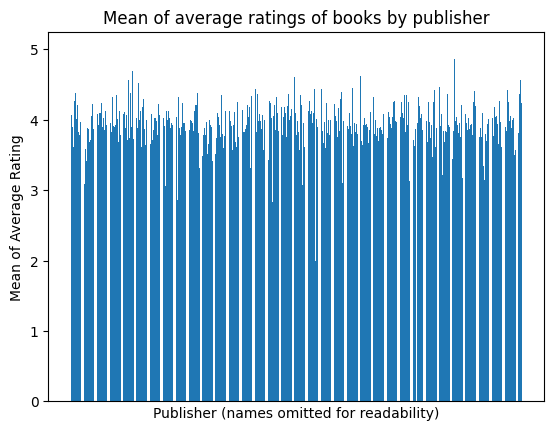

In [ ]:
avg_rating_by_publisher = books_df.groupby("publisher")['average_rating'].mean()
avg_rating_by_publisher
plt.bar(avg_rating_by_publisher.index, avg_rating_by_publisher.values)
plt.title("Mean of average ratings of books by publisher")
plt.xticks([])
plt.xlabel("Publisher (names omitted for readability)")
plt.ylabel("Mean of Average Rating")
plt.show()

3. Z-Test for Relationship between Average Number of Pages and Language

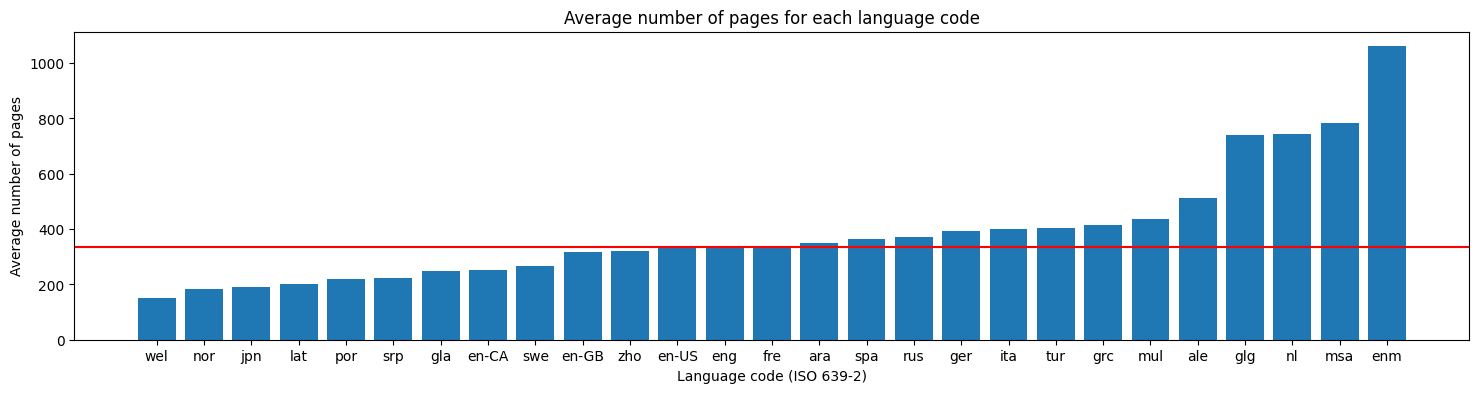

In [ ]:
avg_page_per_language = books_df.groupby("language_code")['num_pages'].mean().sort_values()
plt.figure(1, [18, 4])
mean_pages = books_df['num_pages'].mean()
plt.title("Average number of pages for each language code")
plt.xlabel("Language code (ISO 639-2)")
plt.ylabel("Average number of pages")
plt.axline((0,mean_pages),slope=0,color="red")
plt.bar(avg_page_per_language.index, avg_page_per_language.values)
plt.show()

While it's clear that there are some big outliers, mainly "enm", which is Middle English, most of the values hover around the red line, which is the mean number of pages across all languages. The median, at 299 compared to the mean of approximately 336, is also quite close to the mean, so there isn't much of a skew; there are outliers on both ends, although the outliers on the higher end tend to deviate from the mean more than the outliers on the lower end.

To look at a concrete example, we can use a Z-test to see if the mean for Japanese is significantly different than the overall mean. Japanese is chosen because it's not incredibly close to the mean but not as much of an outlier as Middle English, and because there are more Japanese books in the database than those of many other languages. The below code shows that there are 46 books in Japanese in the data set, which is enough to satisfy the Central Limit Theorem for a Z-test.

In [ ]:
len(books_df[books_df['language_code'] == 'jpn'])

46

$H_0$ : The mean number of pages for Japanese books is not significantly different from the mean number of pages for all books.

$H_A$: The mean number of pages for Japanese books is significantly different from the mean number of pages for all books.

$\alpha$

This will be a one-tailed test, since we can see from the graph that the mean is lower. With this $\alpha$, the critical value for a left-tailed Z-test is -1.6448536.

To conduct the Z-test, all we need to do is calculate the z-score and compare it to the critical value.

In [ ]:
import math
jpn_mean = books_df[books_df['language_code'] == 'jpn']['num_pages'].mean()
std_pages = books_df[books_df['language_code'] == 'jpn']['num_pages'].std()
zscore = (jpn_mean-mean_pages)/(std_pages)
zscore

-15.816335911807593

The Z-score is less than the critical value of $-1.6448536$, so we reject the null hypothesis; there exists sufficient evidence to conclude that the language of a book being Japanese has an effect on its page length.

#5. Primary Analysis

Since we are attempting to predict the average rating of a book (a continuous label) given several continuous features, the best type of model for the task is a linear regression model.

First we import the libraries necessary for creating and training the linear regression model.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
!pip3 install torchmetrics
import torchmetrics
random_state = 42


ModuleNotFoundError: No module named 'torchmetrics'

We drop incomplete rows and the columns which we are not considering:
*   Book ID
*   Title
*   Average Rating (this is the label we are trying to predict, so we drop it from the training set)
*   ISBN
*   ISBN13

The following discrete columns have been label encoded, so we drop the text columns (one-hot encoding would not be suitable given the large size of the inputs, so label encoding was used instead):
*   Authors
*   Language Code
*   Publisher

The following discrete column was broken up into three continuous columns to allow for regression:
*   Publication Date (separated into the columns Day, Month, and Year)

The following columns were dropped for being deemed irrelevant given the timescale present in the dataset (as according to the Curse of Dimensionality, we want to remove unecessary dimensions wherever possible to reduce sparcity of data):
*   Month
*   Day





In [ ]:
import numpy as np

books_df = books_df.dropna()
X = books_df.drop(columns=["bookID", "title", "average_rating", "language_code", "isbn", "isbn13", "authors", "publisher", "publication_date"])
y = books_df[["average_rating"]].to_numpy()

X["num_pages"] = X["num_pages"].replace(0,1)
X["num_pages"] = np.log(X["num_pages"])
X["ratings_count"] = X["ratings_count"].replace(0,1)
X["ratings_count"] = np.log(X["ratings_count"])
X["text_reviews_count"] = X["text_reviews_count"].replace(0,1)
X["text_reviews_count"] = np.log(X["text_reviews_count"])
X.shape


(11117, 30)

Now we prepare the dataset for neural network training.

In [ ]:
torch.set_default_dtype(torch.float64)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
scaler = StandardScaler()
X = scaler.fit_transform(X, y)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size= 0.2,random_state=random_state)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(Y_test)), batch_size=32, shuffle=False)

batch_size = train_loader.batch_size
num_train_data = len(train_loader.dataset)
num_test_data = len(test_loader.dataset)
feat_dim = len(train_loader.dataset.tensors[0][0])

cuda:0
1


We scale the training set and testing set to be uniform:

In [ ]:

class BookML(nn.Module):
    def __init__(self, feat_dim):
        super(BookML, self).__init__()
        self.fc1 = nn.Linear(feat_dim, 30)
        self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(15, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = F.relu(self.fc3(x2))
        return self.fc4(x3)

model = BookML(feat_dim)

num_layers = len(list(model.children()))
input_dim = list(model.children())[0].in_features
output_dim = list(model.children())[-1].out_features

print("Number of Layers:", num_layers)
print("Input Dimension:", input_dim)
print("Output Dimension:", output_dim)

Number of Layers: 4
Input Dimension: 30
Output Dimension: 1


We use scikit-learn's Linear Regression model for the analysis:

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass: calculates losses from the data and your model. (2-3 lines)
        ### YOUR ANSWER HERE
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, targets)
        # Backward pass: updates your network from the loss gradients. (3-4 lines)
        ### YOUR ANSWER HERE
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss = running_loss / len(train_loader)
    losses.append(running_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss}')

print('Finished Training')

Epoch 1/100, Loss: 0.11123306510822713
Epoch 11/100, Loss: 0.11037168491672177
Epoch 21/100, Loss: 0.11037086338201933
Epoch 31/100, Loss: 0.11030982065790272
Epoch 41/100, Loss: 0.11030173843554993
Epoch 51/100, Loss: 0.11025262888033245
Epoch 61/100, Loss: 0.11015714206776386
Epoch 71/100, Loss: 0.11017667222937583
Epoch 81/100, Loss: 0.11008189647366702
Epoch 91/100, Loss: 0.11016831480553721
Finished Training


Train Loss: 0.1100985329237555
Test Loss: 0.10065643064263


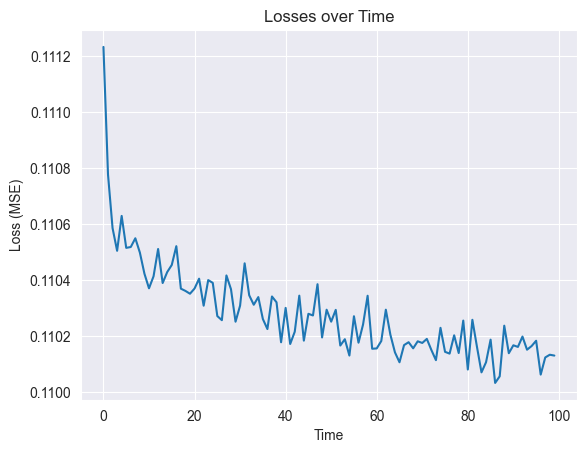

In [ ]:
test_loss = 0.0
for batch_idx, (data, targets) in enumerate(test_loader):
    loss = criterion(model(data), targets)
    test_loss += loss.item()
test_loss = test_loss / len(test_loader)

train_loss = 0.0
for batch_idx, (data, targets) in enumerate(train_loader):
    loss = criterion(model(data), targets)
    train_loss += loss.item()
train_loss = train_loss / len(train_loader)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

plt.plot(losses)
plt.title("Losses over Time")
plt.xlabel("Time")
plt.ylabel("Loss (MSE)")
plt.show()

Clearly the correlation coefficient ${R^2}$ is very low, meaning that less than 2% of the variance in the model can be explained by a linear relationship between the features and the label. So there is almost no linear relationship between the average rating and the other columns in the dataset.

#6. Visualization


We claim that there is no error with our model, but rather that the very low $R^2$ can be explained by the lack of correlation between our predictor variables and the rating. Experimenting with different combinations of the predictor variables, such as omitting some of the predictor variables to avoid the curse of dimensionality, yield a similar $R^2$ of less than 2%.

We'll show that there genuinely is very little connection between the data by using Seaborn to display a heatmap.

First, we need to determine the correlation for our predictor variables and our target variable. We can do this by creating a correlation matrix, and then focusing on the last column, which stores the correlations between the average rating and our predictors.

In [ ]:
target = torch.tensor(y)
pred = model(torch.tensor(X))
r2score = torchmetrics.R2Score()
r2 = r2score(pred, target).item()
print(f"The R^2 of our model is {r2}")

The R^2 of our model is 0.11865511984526933


As you can see in this heatmap, there is very little correlation between any of the predictor variables and the average rating individually. The best at estimating the average rating is the rating count, but even that has an extremely weak correlation of 0.10. If the predictor variables are this weakly correlated with the average rating, then any model we create will not be able to predict the rating well, as it would have to invent patterns to pick up on. In fact, the fact that our model has such a low $R^2$ indicates that we did not overfit it, as one sign of overfitting is being too sensitive to noise in the data.


#7. Insights and Conclusions

Based on the poor performance of the model and the visualization explaining that the failure of the model is not due to flaws with the model's construction, we can conclude that it is not possible to meaningfully predict a book's rating based on the data that the Goodreads API gives us, namely the language, pages, review count, and publication details. In some sense, this is a reassurance to readers who use Goodreads as a resource, and authors who are looking to publish.

On the author side, these results indicate that books of all languages, all lengths, and all publication details are able to get high reviews from readers. Authors can use this information to give themselves more freedom with the types of books they want to write, as these factors alone do not determine the book's success.

On the reader side, readers can determine that books with few reviews can still have high quality, and that people do not rate popular books higher simply because they're popular. If the latter were the case, then we'd expect there to be a positive correlation between ratings and review count, but the one that's there is extremely weak and not an indication of any sort of relationship.

There may be other factors to consider that may have been able to partially predict a book's rating. Genre, for example, might have some predictive potential, but the Goodreads API does not provide that information, and we could not find any additional source that has the genres for all these books available. However, what we do know is that the information Goodreads gives us is not enough to predict the average rating of a book.